In [2]:
using Revise
using PyPlot
using Infiltrator
using LinearAlgebra
using Bem2d
using PyCall

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /root/.julia/packages/Revise/lwch5/src/Revise.jl:866


In [13]:
mu = 3e10
lambda = mu
nu = 0.25
rho = 2700
width = 10e3
g = 9.81
nels = 50
npts = 100
L = 1e4
offset = 100

100

In [14]:
top = 0
x, y = obsgrid(-L+offset, top-2*L+offset, L-offset, top-offset, npts) 
els = Elements(Int(1e5))
addelsez!(els, discretizedline(-L, top-2*L, L, top-2*L, nels)..., "B") # Bottom
addelsez!(els, discretizedline(L, top-2*L, L, top, nels)... , "R") # Right hand side
addelsez!(els, discretizedline(L, top, -L, top, nels)..., "T") # Top
addelsez!(els, discretizedline(-L, top, -L, top-2*L, nels)..., "L") # Left hand side

In [15]:
all_idx = 1:1:els.endidx
T_pU_qall, _ = PUTC(slip2dispstress, els, all_idx, all_idx, mu, nu)
T = T_pU_qall

400×400 Array{Float64,2}:
  0.5          0.0          0.0        …   0.21865      -0.127574   
  0.0          0.5         -0.0582832     -0.042191      0.133767   
  0.0         -0.0582832    0.5            0.142554     -0.0424014  
  0.0582832    0.0          0.0           -0.022893      0.0446128  
  0.0         -0.0271001    0.0            0.0971468    -0.0185719  
  0.0271001    0.0          0.0582832  …  -0.010698      0.0239721  
  0.0         -0.0178504    0.0            0.0723201    -0.0100893  
  0.0178504    0.0          0.0271001     -0.00592627    0.0162655  
  0.0         -0.0133326    0.0            0.0572712    -0.0062717  
  0.0133326    0.0          0.0178504     -0.0037145     0.0123333  
  0.0         -0.0106459    0.0        …   0.0472988    -0.00425801 
  0.0106459    0.0          0.0133326     -0.0025326     0.00995039 
  0.0         -0.00886249   0.0            0.0402411    -0.00307377 
  ⋮                                    ⋱                            
  0.0099

In [16]:
# Modified displacment BCs for bottom
Upart, _ = gravityparticularfunctions(els.xcenter[all_idx], els.ycenter[all_idx], g, rho, lambda, mu)
bcs = zeros(2 * els.endidx)
bcs[1:2:8*nels] = -Upart[:, 1]
bcs[2:2:8*nels] = -Upart[:, 2]

200-element Array{Float64,1}:
 -71.51710725       
 -71.09331524999999 
 -70.68718125       
 -70.29870525       
 -69.92788725       
 -69.57472725       
 -69.23922524999999 
 -68.92138125       
 -68.62119525       
 -68.33866725       
 -68.07379725       
 -67.82658525       
 -67.59703125       
   ⋮                
 -44.77848075       
 -46.844466749999995
 -48.963426749999996
 -51.13536075       
 -53.360268749999996
 -55.638150749999994
 -57.96900675       
 -60.352836749999994
 -62.78964075       
 -65.27941874999999 
 -67.82217075       
 -70.41789675       

In [17]:
Ueff = T \ bcs

400-element Array{Float64,1}:
   48.99408824913694 
 -113.27263951414831 
   47.66051257932452 
 -121.74559387561678 
   46.039593887967115
 -127.64316800068325 
   44.259936083763705
 -132.24486128359908 
   42.389500255610976
 -136.01441777165402 
   40.46043524887858 
 -139.18795011044176 
   38.49057642766702 
    ⋮                
   41.494332199538235
  -65.29401714155004 
   41.95838037546742 
  -70.43064296073376 
   42.331553808935304
  -75.81994165594426 
   42.62200008537046 
  -81.51157290197553 
   42.873330815062594
  -87.5693542418253  
   43.34457228407837 
  -93.80602150710504 

In [18]:
function interior_eval(x, y)
    out = constdispstress(slip2dispstress, x, y, els, all_idx, Ueff[1:2:end], Ueff[2:2:end], mu, nu)[1]
    out += gravityparticularfunctions(x, y, g, rho, lambda, mu)[1]
    return out
end
bem_val = interior_eval([0], [-L])'

2×1 Adjoint{Float64,Array{Float64,2}}:
   1.1102230246251565e-16
 -13.422958363845659     

In [19]:
# Forward solution on grid
Ucomp, _ = constdispstress(slip2dispstress, x, y, els, all_idx, Ueff[1:2:end], Ueff[2:2:end], mu, nu)
Uint, _ = gravityparticularfunctions(x, y, g, rho, lambda, mu)
Utotal = Ucomp .+ Uint
Umag = sqrt.(Utotal[:, 1].^2 + Utotal[:, 2].^2)

10000-element Array{Float64,1}:
 1.170950305611246   
 0.7740994111624653  
 0.6271013415380498  
 0.527941126462416   
 0.515902186185105   
 0.4034354306626553  
 0.4510519997110672  
 0.32647470065981227 
 0.4080464404059125  
 0.27359924173786043 
 0.37680693251897157 
 0.23542256740012726 
 0.35270310989523607 
 ⋮                   
 0.32718716030706196 
 0.006566800973160582
 0.32324891714814163 
 0.02520293763768711 
 0.31805329220101364 
 0.0580497965600338  
 0.31166039836325005 
 0.09970795274692014 
 0.3047782605612264  
 0.15937903068683323 
 0.3004730784493413  
 0.3816561118940231  

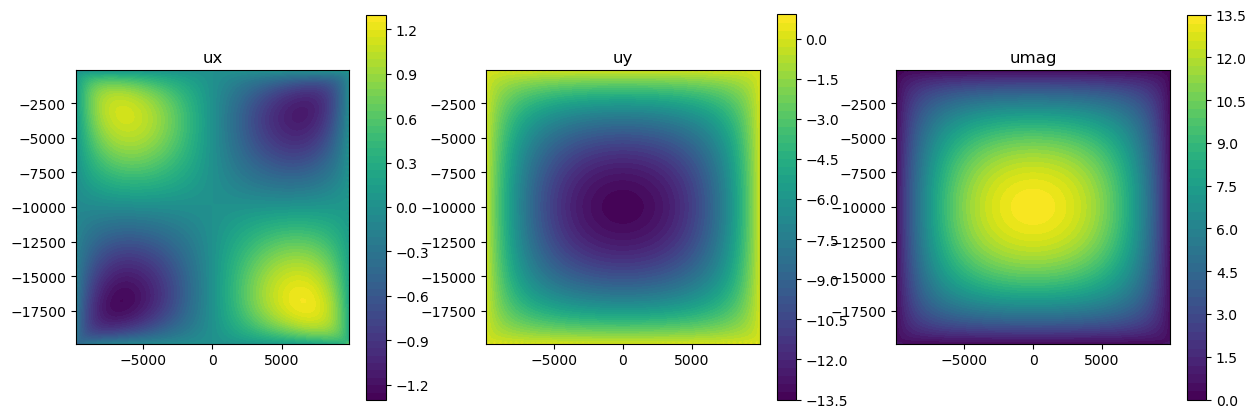

PyObject Text(0.5, 1.0, 'umag')

In [20]:
figure(figsize=(15, 5))

subplot(1, 3, 1)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Utotal[:, 1], npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("ux")

subplot(1, 3, 2)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Utotal[:, 2], npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("uy")

subplot(1, 3, 3)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Umag, npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("umag")